# Inverse Problem: recovering permeability filed from sparse, noisy observation
[DGenNO: A Novel Physics-aware Neural Operator for Solving Forward and Inverse PDE Problems based on Deep, Generative Probabilistic Modeling](https://arxiv.org/pdf/2502.06250)

## (1) Prepare data

a shape: torch.Size([1, 841, 1])
u shape: torch.Size([1, 841, 1])
u_noise shape: torch.Size([1, 841, 1])
x shape: torch.Size([1, 841, 2])
**********************************
The observed positions size: (25,)


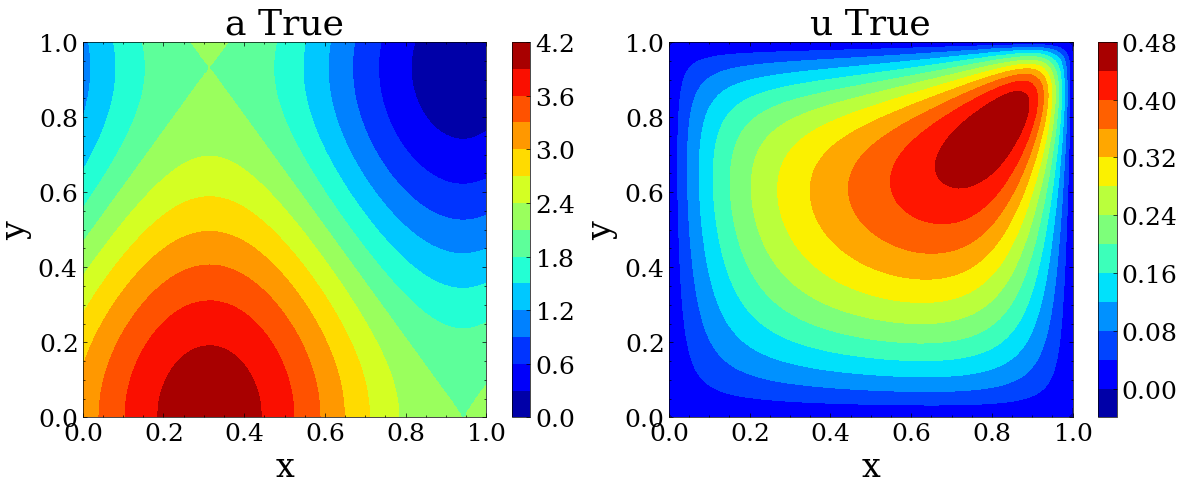

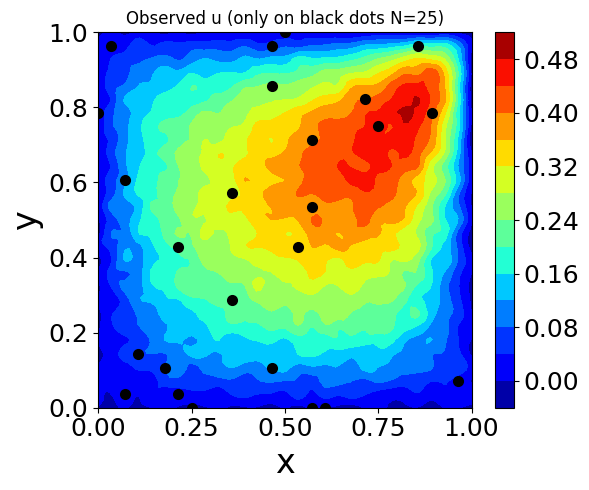

In [1]:
import sys 
sys.path.append("..") 
import numpy as np
import h5py 
import torch 
import random
import matplotlib.pyplot as plt
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 1234
setup_seed(random_seed)
device = 'cpu'
dtype = torch.float32
noise_level = 'SNR25'

######################################
# Load training data
######################################
data = h5py.File('dataset/smh_inverse_coe.mat', 'r')
######################################
from Utils.utils import *
def get_data(data, dtype, N=25):
    gridx = np2tensor(np.array(data["x"]), dtype)
    a = np2tensor(np.array(data["a"]), dtype)
    u = np2tensor(np.array(data["u"]), dtype)
    index_obs = np.array(data["index_obs"])
    ##########################
    sig_avg_watts = torch.mean(u**2)
    #
    if noise_level=='SNR20':
        scale = np.sqrt(sig_avg_watts/10**(20/10))
        u_noise = u + torch.randn_like(u) * scale
    elif noise_level=='SNR25':
        scale = np.sqrt(sig_avg_watts/10**(25/10))
        u_noise = u + torch.randn_like(u) * scale
    elif noise_level=='SNR50':
        scale = np.sqrt(sig_avg_watts/10**(50/10))
        u_noise = u + torch.randn_like(u) * scale
    elif noise_level=='SNR100':
        scale = np.sqrt(sig_avg_watts/10**(100/10))
        u_noise = u + torch.randn_like(u) * scale
        
    return a.unsqueeze(0), u.unsqueeze(0), u_noise.unsqueeze(0), gridx, index_obs[0:N]
#
a_true, u_true, u_noise, gridx, inx_obs = get_data(data, dtype)
x = gridx.unsqueeze(0)
print('a shape:', a_true.shape)
print('u shape:', u_true.shape)
print('u_noise shape:', u_noise.shape)
print('x shape:', x.shape)
print('**********************************')
print('The observed positions size:', inx_obs.shape)
########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list([gridx]*2, [a_true, u_true], ['a True', 'u True'], lb =0.)
#########################################
#The observations (sparse and noisy)
#########################################
from scipy.interpolate import griddata
plt.figure(figsize=(6,5))
mesh = np.meshgrid(np.linspace(0., 1., 100), np.linspace(0., 1., 100))
x_plot, y_plot = mesh[0], mesh[1]
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_noise), (x_plot, y_plot), method='cubic')
cntr = plt.contourf(x_plot, y_plot, z_plot, levels=14, cmap='jet')
plt.scatter(x[0,inx_obs,0], x[0,inx_obs,1], color='k', linewidth=2.)
plt.colorbar(cntr)
plt.title('Observed u (only on black dots N=25)', fontsize=12)
plt.xlabel('x')
plt.ylabel('y')
#
plt.tight_layout()
plt.show()

## (2) Define the loss class

### (2.1) load the trained forward model

In [2]:
######################################
# load the trained forward model
######################################
import torch.nn as nn
from Networks.EncoderNet import EncoderCNNet2d
class Encoder(nn.Module):
    def __init__(self, conv_arch:list, fc_arch:list, 
                 nx_size:int, ny_size:int, dtype=None):
        super(Encoder, self).__init__()
        self.conv = EncoderCNNet2d(conv_arch=conv_arch, fc_arch=fc_arch,
                                   activation_conv='SiLU', activation_fc='SiLU',
                                   nx_size=nx_size, ny_size=ny_size, 
                                   kernel_size=(3,3), stride=2, dtype=dtype)
        
    def forward(self, feat):
        '''
        Input:
            feat: size(?, ny*nx, 1)
        Return:
            output: size(?, out_size)
        '''
        beta = self.conv(feat)
        
        return torch.tanh(beta)
#
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/DGNO_latent128/', 
                                 name=f'model_dgno_besterror')

####################################### The beta model
from Networks.EncoderNet import EncoderFCNet
class BetaModel(nn.Module):
    def __init__(self, layers_beta, act_beta, dtype=None):
        super(BetaModel, self).__init__()
        self.fc = EncoderFCNet(layers_beta, act_beta, dtype=dtype)
        
    def forward(self, ones):
        '''
        Input:
            ones: size(?, ny*nx, 1)
        Return:
            output: size(?, out_size)
        '''
        beta = self.fc(ones)
        beta = torch.tanh(beta)
        
        return beta
#
layers_beta, act_beta = [1, 64, 64, 128], 'ReLU'
model_beta = BetaModel(layers_beta, act_beta, dtype=dtype).to(device)

### (2.2) Define the loss class

In [3]:
###############################
# Define Loss Class
###############################
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
#####
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
##### The test function
int_grid, v, dv_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=7, dataType=dtype).get_testFun()
print('int_grid shape:', int_grid.shape, 'v shape:', v.shape)

###############################
class mollifier(object):

    def __inint__(self):
        super(mollifier, self).__init_()
        
    def __call__(self, u, x):
        u = u * torch.sin(np.pi * x[...,0])*torch.sin(np.pi * x[...,1])
        
        return u.unsqueeze(-1)
        
################################
class LossClass(object):

    def __init__(self, model_beta):
        super(LossClass, self).__init__()
        ''' '''
        self.device = device
        self.mollifier = mollifier()
        self.model_u = model_trained['u']
        self.model_a = model_trained['a']
        self.model_beta = model_beta
        self.ones = torch.ones((1,1,1)).to(device)
        #######################
        self.n_grid = int_grid.shape[0]
        self.int_grid = int_grid.to(device)
        self.v = v.to(device)
        self.dv_dr = dv_dr.to(device)
        #
        self.inx_obs = inx_obs

    def Loss_pde(self, nc=100):
        beta = self.model_beta(self.ones)
        n_batch = 1
        ############### Data points ###############
        # xc:size(nc, 1, 2) R:size(nc, 1, 1)
        xc, R = pointGen.weight_centers(n_center=nc, R_max=1e-4, R_min=1e-4)
        xc, R = xc.to(self.device), R.to(self.device)
        # size(nc, n_grid, 2)
        x = self.int_grid * R + xc
        # size(nc*n_grid, 2) -> (n_batch, nc*n_grid, 2)
        x = x.reshape(-1, 2).repeat((n_batch,1,1))
        x = Variable(x, requires_grad=True)
        ############### Test functions #############
        v = self.v.repeat((nc,1,1)).reshape(-1,1)
        dv = (self.dv_dr / R).reshape(-1, 2)
        ################ model prediction ###########
        a_detach = self.model_a(x.detach(), beta)
        a_detach = a_detach.unsqueeze(-1)
        # u: size(n_batch, nc*n_grid, 1)
        u = self.model_u(x, beta)
        u = self.mollifier(u, x)
        # du: size(n_batch, nc*n_grid, 2)
        du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f = 10. * torch.ones_like(u)
        ################ PDE loss ####################  
        # size(n_batch, nc*n_grid, 2) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        left = torch.sum( a_detach * (du * dv), dim=-1).reshape(n_batch, nc, self.n_grid)
        left = torch.mean(left, dim=-1)
        # size(n_batch, nc*n_grid, 1) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        right = (f * v).reshape(n_batch, nc, self.n_grid)
        right = torch.mean(right, dim=-1)
        #
        loss_pde = torch.norm(left-right, 2, 1)

        return torch.mean(loss_pde)
        
    def Loss_data(self, x, u):
        '''Note: observations are available on positions: 'inx_obs'
        '''
        x_obs = x[:,self.inx_obs,:]
        u_obs = u[:,self.inx_obs,:]
        #
        beta = self.model_beta(self.ones)
        u_pred = self.model_u(x_obs, beta)
        u_pred = self.mollifier(u_pred, x_obs)
        #
        loss_u = torch.norm(u_pred-u_obs, 2, 1) / torch.norm(u_obs, 2, 1)
        
        return torch.mean(loss_u)

    def Error(self, x, a):
        beta = self.model_beta(self.ones)
        a_pred = self.model_a(x, beta)
        #
        err_a = torch.norm(a_pred-a.squeeze(-1), 2, 1) / torch.norm(a.squeeze(-1), 2, 1)

        return torch.mean(err_a)

int_grid shape: torch.Size([25, 2]) v shape: torch.Size([25, 1])


## (3) solve the optimization problem

In [4]:
import os
import time
from tqdm import trange

epochs = 1000
lr = 1e-2
w_data, w_pde = 25., 1.
optimizer = torch.optim.Adam(params=model_beta.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.6)
loss_list, error_list = [], []
t0 = time.time()
for epoch in trange(epochs):
    lossClass = LossClass(model_beta)
    loss_pde = lossClass.Loss_pde()
    loss_data = lossClass.Loss_data(x, u_noise)
    loss_train = w_pde * loss_pde + w_data * loss_data
    #
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    scheduler.step()  # Adjust learning rate
    #
    with torch.no_grad():
        error = lossClass.Error(x, a_true)
        error_list.append(error.item())
    #
    loss_list.append(loss_train.item())
    if (epoch+1)%100==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}')
        print('error_test:', error_list.pop())
print('The consuming time is:', time.time()-t0)
############################################## save the trained model
def saveModel(path:str, model):
    '''Save trained model (the whole model)
    '''
    if not os.path.exists(path):
        os.makedirs(path)
    #
    torch.save(model, path+'dgno_inverse_N25.pth')
#
saveModel(f'saved_models/DGNO_inverse_{noise_level}/', model_beta)

 10%|████▎                                     | 103/1000 [00:03<00:28, 30.94it/s]

Epoch:99, The loss is:1.7201101779937744
error_test: 0.015130797401070595


 20%|████████▌                                 | 203/1000 [00:07<00:26, 30.64it/s]

Epoch:199, The loss is:1.9626343250274658
error_test: 0.015322986990213394


 31%|████████████▊                             | 306/1000 [00:10<00:22, 31.24it/s]

Epoch:299, The loss is:1.6762499809265137
error_test: 0.01811763271689415


 40%|████████████████▉                         | 402/1000 [00:13<00:19, 30.88it/s]

Epoch:399, The loss is:1.6796274185180664
error_test: 0.020229190587997437


 51%|█████████████████████▎                    | 506/1000 [00:17<00:15, 31.00it/s]

Epoch:499, The loss is:1.6424996852874756
error_test: 0.018358303233981133


 61%|█████████████████████████▍                | 606/1000 [00:20<00:12, 30.90it/s]

Epoch:599, The loss is:1.6563022136688232
error_test: 0.021350543946027756


 70%|█████████████████████████████▌            | 703/1000 [00:23<00:09, 30.78it/s]

Epoch:699, The loss is:1.639291524887085
error_test: 0.019584394991397858


 80%|█████████████████████████████████▋        | 803/1000 [00:26<00:06, 31.12it/s]

Epoch:799, The loss is:1.6156684160232544
error_test: 0.020874232053756714


 90%|█████████████████████████████████████▉    | 903/1000 [00:29<00:03, 30.66it/s]

Epoch:899, The loss is:1.6879626512527466
error_test: 0.021423088386654854


100%|█████████████████████████████████████████| 1000/1000 [00:33<00:00, 30.24it/s]

Epoch:999, The loss is:1.7418859004974365
error_test: 0.018270915374159813
The consuming time is: 33.07569479942322


## (4) Plot the recovered result

The test l2 error (u avg): tensor(0.0260)
The test l2 error (a avg): tensor(0.0183)


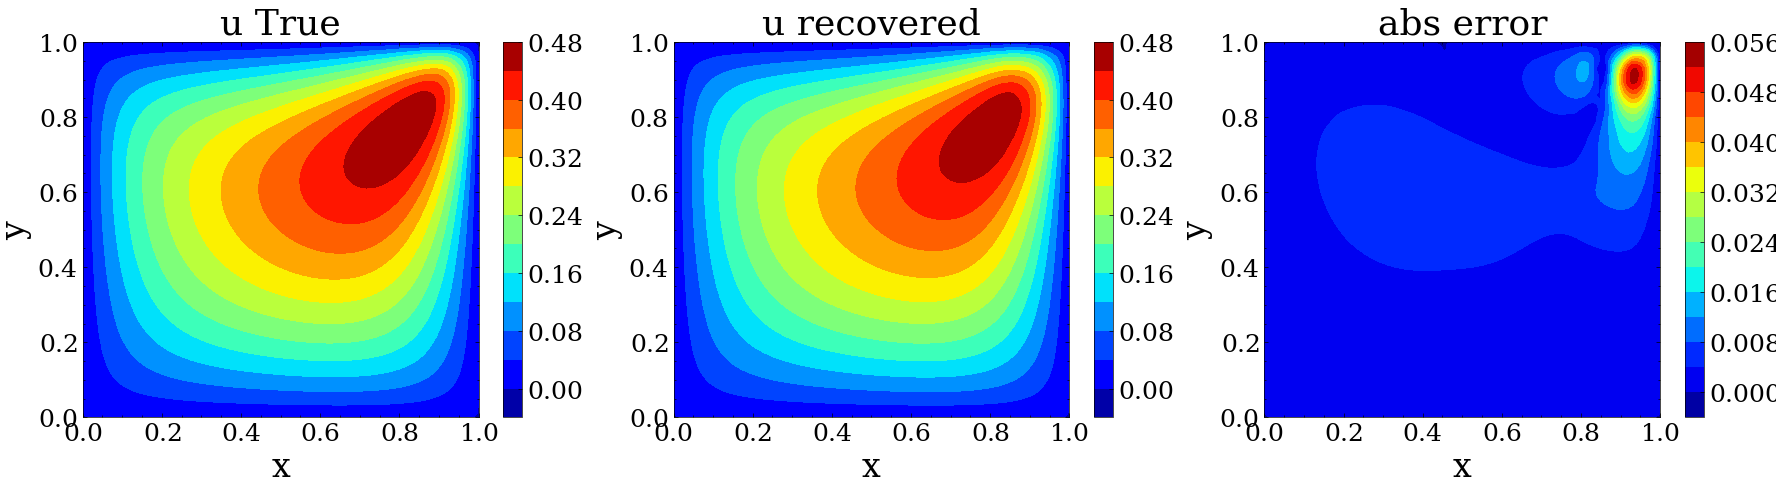

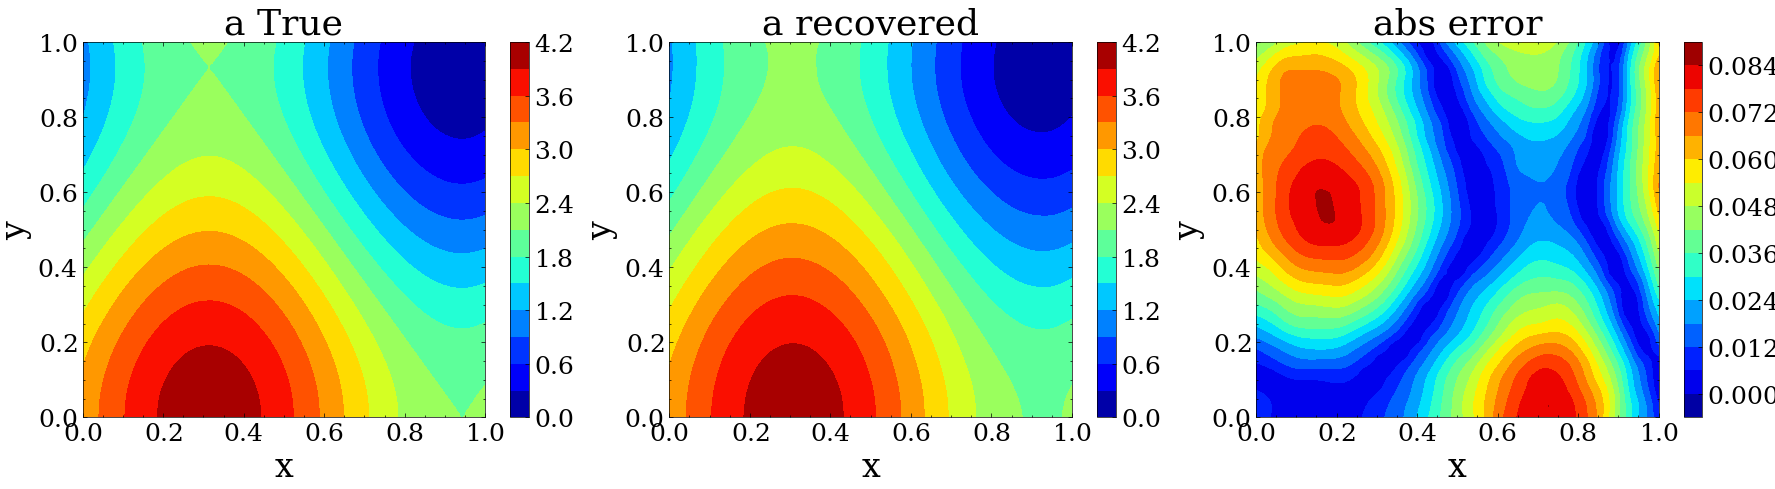

In [5]:
################################## make prediction
with torch.no_grad():
    x_var = x.to(device)
    beta_pred = model_beta(torch.ones((1,1,1)).to(device))
    #
    u_pred = model_trained['u'](x_var, beta_pred)
    u_pred = mollifier()(u_pred, x_var).detach().cpu()
    a_pred = model_trained['a'](x_var, beta_pred).detach().cpu().unsqueeze(-1)
#
print('The test l2 error (u avg):', solver.getError(u_pred, u_true))
print('The test l2 error (a avg):', solver.getError(a_pred, a_true))
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list(gridx, [u_true, u_pred, abs(u_pred-u_true)],
                  ['u True', 'u recovered', 'abs error'], lb=0.)
Plot.show_2d_list(gridx, [a_true, a_pred, abs(a_pred-a_true)], 
                  ['a True', 'a recovered', 'abs error'], lb=0.)